In [1]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

from collections import defaultdict #, Counter
from transformers import AutoModelForMaskedLM, AutoTokenizer

from operator import mul
from functools import reduce


device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'bert-base-multilingual-uncased'
MASK_TOKEN = '[MASK]'
PAD_TOKEN = '[PAD]'
BOS_TOKEN = '[CLS]'
EOS_TOKEN = '[SEP]'

KWORDS_THING = ('quoi que ce soit','quoi que ce soit','quoi que ce soit','quoi que ce soit')
KWORDS_BODY  = ('qui que ce soit','qui que ce soit','qui que ce soit','qui que ce soit')
INPUT_FILE = 'fr_test_sentences_newwords.tsv'

PREFIX = 'fr_mbert'

BATCH_SIZE = 40 
assert BATCH_SIZE%4 == 0, '# important to have BATCH_SIZE%4 == 0'

RANDOM_TOKENS = 40

keywords = list(set(KWORDS_THING)|set(KWORDS_BODY))


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(['[NOT]','[FEW]','[MANY]'], special_tokens=True)

model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
# let's check the number of tokens in our keywords

torch.manual_seed(0)
np.random.seed(0)

keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
#     keywords2random_tokens[keyword] = np.random.choice(range(max(reverse_vocab)), (TEST_CASES_PER_SIZE,len(tokens)))
    print(len(tokens), tokens)

random_tokens = dict()
for tok in ('[NOT]', '[FEW]', '[MANY]'):
    random_tokens[tok] = np.random.choice(range(max(reverse_vocab)), RANDOM_TOKENS)

4 ['quoi', 'que', 'ce', 'soit']
4 ['qui', 'que', 'ce', 'soit']


In [3]:
random_tokens

{'[NOT]': array([ 68268,  43567,  42613,  45891,  21243,  95939,  97639,  41993,
         86293,  55026,  80471,  80966,  48600,  39512,  52620,  80186,
         17089,  32230,  18983,  89688, 101201,  82457,  93005, 104520,
          6921,  38804,  67699,  70608,  37619,   7877,  83966,   1871,
         73135,   2496,  47954,  24675,  31921,  99059,    797,  49811]),
 '[FEW]': array([68755, 80782, 90535, 81857, 52489, 84665, 41504, 49866, 84212,
        96766, 11723, 43890, 17591, 58146, 92288, 59300, 89141, 71557,
        20006,  3560, 90868, 61713, 96591, 45444, 46522, 86904, 20737,
        28647, 61353, 92217, 80163, 12134, 60535, 47883, 86107, 63360,
        51811,  9781, 19340, 27257]),
 '[MANY]': array([ 16298,  12372,   4420, 105412,  82991,  62079,  79860, 103555,
          7012,   9396,   3918,   9359,  44259,  23482,  15127, 101261,
         37237,  79701,   8752,  80041,  71331,  50624,  89183,  40133,
         93790,  55153, 102066,  62756,  90928,  81757,  84355,  99938,


In [4]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return [BOS_TOKEN,] + tokenizer.tokenize( 
        sent.replace(kword, f'{MASK_TOKEN} '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + [EOS_TOKEN,]

tokenized_array = []
metadata_array = []

lines = [line for idx, line in enumerate(open(INPUT_FILE, encoding='utf-8'))]

np.random.seed(0)
np.random.shuffle(lines)

for idx, line in enumerate(lines):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = KWORDS_THING
    else:
        kwords = KWORDS_BODY
    
    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [5]:
def assess_batch(batch, metas, r_idx):
    global scores
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
    
    for idx, s in enumerate(batch):
        mask_positions.append( s.index(MASK_TOKEN) )
        mask_lens.append( s.count(MASK_TOKEN) )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + [PAD_TOKEN,]*(max_len-len(s)))
        for tok in ('[NOT]', '[FEW]', '[MANY]'): # replace spec tokens with random ones
            if tok in s:
                input_ids[s.index(tok)] = random_tokens[tok][r_idx]

        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4], 2)

[5.657305657259036e-16,
 7.350508392487928e-15,
 2.0825095060433558e-15,
 4.913716344780052e-15,
 9.683557719052586e-17,
 7.360538178429063e-15,
 6.350888617272028e-15,
 1.4164861795435228e-14]

In [6]:
# assess all the sentences

scores = defaultdict(list)
for b_idx, idx in enumerate(range(0, len(tokenized_array), BATCH_SIZE)):
    if not idx%200: print(f'{idx/(len(tokenized_array)):.2%}')
    scores[b_idx%RANDOM_TOKENS].extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], 
                                                     metadata_array[idx:idx+BATCH_SIZE], 
                                                     b_idx%RANDOM_TOKENS) ) # here we select the set of random tokens

0.00%
0.50%
1.00%
1.50%
2.00%
2.50%
3.00%
3.50%
4.00%
4.50%
5.00%
5.50%
6.00%
6.50%
7.00%
7.50%
8.00%
8.50%
9.00%
9.50%
10.00%
10.50%
11.00%
11.50%
12.00%
12.50%
13.00%
13.50%
14.00%
14.50%
15.00%
15.50%
16.00%
16.50%
17.00%
17.50%
18.00%
18.50%
19.00%
19.50%
20.00%
20.50%
21.00%
21.50%
22.00%
22.50%
23.00%
23.50%
24.00%
24.50%
25.00%
25.50%
26.00%
26.50%
27.00%
27.50%
28.00%
28.50%
29.00%
29.50%
30.00%
30.50%
31.00%
31.50%
32.00%
32.50%
33.00%
33.50%
34.00%
34.50%
35.00%
35.50%
36.00%
36.50%
37.00%
37.50%
38.00%
38.50%
39.00%
39.50%
40.00%
40.50%
41.00%
41.50%
42.00%
42.50%
43.00%
43.50%
44.00%
44.50%
45.00%
45.50%
46.00%
46.50%
47.00%
47.50%
48.00%
48.50%
49.00%
49.50%
50.00%
50.50%
51.00%
51.50%
52.00%
52.50%
53.00%
53.50%
54.00%
54.50%
55.00%
55.50%
56.00%
56.50%
57.00%
57.50%
58.00%
58.50%
59.00%
59.50%
60.00%
60.50%
61.00%
61.50%
62.00%
62.50%
63.00%
63.50%
64.00%
64.50%
65.00%
65.50%
66.00%
66.50%
67.00%
67.50%
68.00%
68.50%
69.00%
69.50%
70.00%
70.50%
71.00%
71.50%
72.00%
72.50

In [7]:
np.array(scores).shape
len(scores)
len(scores[39])

# shape of score is [random_tokens_idx][ (aff_prob, neg_prob, many_prob, few_prob)*items ]

1000

In [8]:
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))

for r_idx in range(RANDOM_TOKENS):
    for score, meta in zip(scores[r_idx], metadata_array):
        if meta[0][0]=='aff':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 0
        if meta[0][0]=='neg':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 1
        if meta[0][0]=='many':
            handle = (meta[0][4], 'many>few')
            k_idx = 0
        if meta[0][0]=='few':
            handle = (meta[0][4], 'many>few')
            k_idx = 1
        handle2 = ('both', handle[1])
        stats[handle][r_idx][k_idx].append( score )
        stats[handle2][r_idx][k_idx].append( score )

# shape of stats now is
#  [handles][random_tokens_idx][(0 for aff and many, 1 for neg and few)][items]
# where handle is one of ('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), 
#                          ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')

In [9]:
measures = dict()
for handle in sorted(stats):
    r = []
    for r_idx in range(RANDOM_TOKENS):
        r.append( np.count_nonzero(list(map(lambda x:x[0]>x[1], zip(stats[handle][r_idx][0],stats[handle][r_idx][1]))))/len(stats[handle][r_idx][0]) )
    print(handle, f'  mean {np.mean(r):0.3%} std {np.std(r):0.3%}')
    measures[handle] = r[:]
    
# shape of measures is 
#   [handles][ random_tokens_idx scores ]

('both', 'aff>neg')   mean 26.160% std 18.506%
('both', 'many>few')   mean 52.640% std 27.351%
('thing', 'aff>neg')   mean 26.160% std 18.506%
('thing', 'many>few')   mean 52.640% std 27.351%


dict_keys([('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

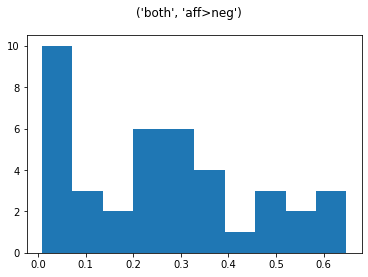

In [10]:
# r
plt.hist(measures[('both', 'aff>neg')])
plt.suptitle(str(('both', 'aff>neg')))
measures.keys()

dict_keys([('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

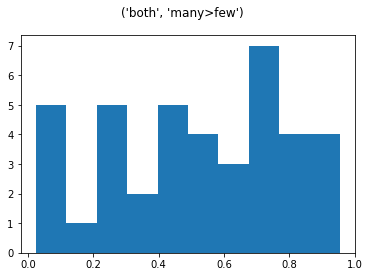

In [11]:
# r
plt.hist(measures[('both', 'many>few')])
plt.suptitle(str(('both', 'many>few')))
measures.keys()

In [12]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_baseline_scores.pkl', 'wb') as f:
    pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)
with open(f'{PREFIX}_baseline_stats.pkl', 'wb') as f:
    dill.dump(stats, f)
with open(f'{PREFIX}_baseline_measures.pkl', 'wb') as f:
    pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        

In [13]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_baseline_measures.pkl', 'rb') as f:
#     pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        
    a = pickle.load(f)
a

{('both', 'aff>neg'): [0.084,
  0.288,
  0.336,
  0.032,
  0.008,
  0.064,
  0.552,
  0.056,
  0.256,
  0.276,
  0.34,
  0.052,
  0.184,
  0.068,
  0.052,
  0.408,
  0.272,
  0.304,
  0.144,
  0.472,
  0.612,
  0.304,
  0.252,
  0.648,
  0.376,
  0.116,
  0.308,
  0.476,
  0.336,
  0.208,
  0.26,
  0.572,
  0.056,
  0.04,
  0.088,
  0.008,
  0.236,
  0.6,
  0.204,
  0.516],
 ('both', 'many>few'): [0.896,
  0.656,
  0.172,
  0.268,
  0.48,
  0.344,
  0.532,
  0.436,
  0.956,
  0.864,
  0.3,
  0.052,
  0.828,
  0.056,
  0.576,
  0.436,
  0.916,
  0.54,
  0.488,
  0.616,
  0.292,
  0.764,
  0.028,
  0.396,
  0.724,
  0.268,
  0.108,
  0.86,
  0.82,
  0.56,
  0.212,
  0.024,
  0.832,
  0.604,
  0.768,
  0.756,
  0.696,
  0.452,
  0.732,
  0.748],
 ('thing', 'aff>neg'): [0.084,
  0.288,
  0.336,
  0.032,
  0.008,
  0.064,
  0.552,
  0.056,
  0.256,
  0.276,
  0.34,
  0.052,
  0.184,
  0.068,
  0.052,
  0.408,
  0.272,
  0.304,
  0.144,
  0.472,
  0.612,
  0.304,
  0.252,
  0.648,
  0.376,
 

Text(0.5, 0.98, "('both', 'aff>neg')")

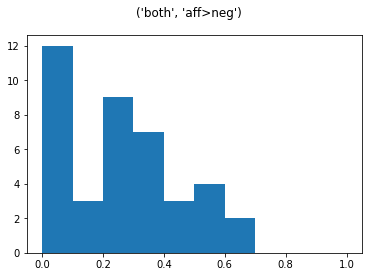

In [14]:
import matplotlib.pyplot as plt

plt.hist(a[('both', 'aff>neg')], range=(0,1))
plt.suptitle(str(('both', 'aff>neg')))
